# BAKU - Prediction Test for archs comparision
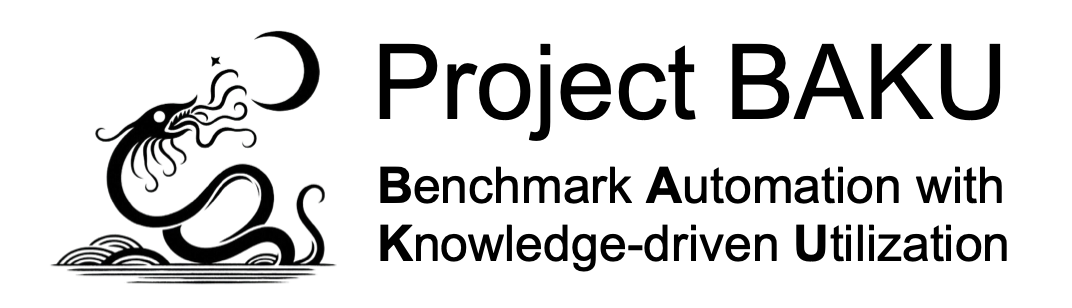


### Imports and Configs

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import sys  
import json
import ast
import json
from itertools import combinations
from collections import defaultdict
import io
# sys.path.insert(1, '../scripts/benchGen_Dataset/')
# import geminiAsker as ga
# #import gptAsker as gpt
# sys.path.insert(2, '../scripts/classes/')
# from data_loader import DataLoader

### Distributions Analyses

#### Functions

In [8]:
df_gpt = pd.read_csv("../data/prediction_test/bg_distributions/gpt-oss-20b-total.csv")
df_opencl = pd.read_csv("../data/prediction_test/bg_distributions/perf_data_opencl.csv")
df_opencl2 = pd.read_csv("../data/prediction_test/bg_distributions/perf_data_opencl2.csv")
df_opencl_mean = pd.read_csv("../data/prediction_test/bg_distributions/opencl_mean_dists.csv")
df_opencl_mean2 = pd.read_csv("../data/prediction_test/bg_distributions/opencl2_mean_dists.csv")
df_gogh = pd.read_csv("../data/prediction_test/bg_distributions/perf_data_gogh.csv")
df_gogh2 = pd.read_csv("../data/prediction_test/bg_distributions/perf_data_gogh2.csv")
df_gogh_mean = pd.read_csv("../data/prediction_test/bg_distributions/gogh_mean_dists.csv")
df_gogh_mean2 = pd.read_csv("../data/prediction_test/bg_distributions/gogh2_mean_dists.csv")

In [ ]:
def analyze_and_plot_distributions(dataframe, program_column, counters, output_csv_filename,plot=True):
    shapiro_results = []
    names = set(dataframe[program_column])

    for name in names:
        df_server = dataframe[dataframe[program_column] == name]

        if plot:
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            fig.suptitle(f'Distributions for {name} ', fontsize=16)
            axes = axes.flatten()

        for i, counter in enumerate(counters):
            stat, p_value = stats.shapiro(df_server[counter])

            shapiro_results.append({
                'program_name': name,
                'counter': counter,
                'statistic': stat,
                'p_value': p_value
            })
            if plot:
                sns.histplot(data=df_server, x=counter, kde=True, ax=axes[i], bins=30)
                axes[i].set_title(f'{counter} distribution')

        if plot:
            plt.tight_layout()
            plt.subplots_adjust(top=0.92)
            plt.show()

    results_df = pd.DataFrame(shapiro_results)
    results_df.to_csv(output_csv_filename, index=False)
    print(f"File '{output_csv_filename}' succefully created.")
    return results_df

In [ ]:
def compare_distributions(df1, name1, df2, name2, program_col, counters, output_csv_filename, plot=True):
    kstest_results = []
    
    common_programs = set(df1[program_col]) & set(df2[program_col])

    for program in common_programs:
        df1_program = df1[df1[program_col] == program]
        df2_program = df2[df2[program_col] == program]

        if df1_program.empty or df2_program.empty:
            continue

        df1_program = df1_program.copy()
        df1_program['source'] = name1
        
        df2_program = df2_program.copy()
        df2_program['source'] = name2
        
        combined_df = pd.concat([df1_program, df2_program])

        if plot:
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            fig.suptitle(f'Comparison for {program} ({name1} vs {name2})', fontsize=16)
            axes = axes.flatten()

        for i, counter in enumerate(counters):
            stat, p_value = stats.kstest(df1_program[counter], df2_program[counter])
            
            kstest_results.append({
                'program_name': program,
                'comparison': f'{name1}_vs_{name2}',
                'counter': counter,
                'statistic': stat,
                'p_value': p_value
            })
            
            if plot:
                sns.ecdfplot(data=combined_df, x=counter, hue='source', ax=axes[i],log_scale=(True,True),complementary=True)
                axes[i].set_title(f'{counter} distribution')
        
        if plot:
            plt.tight_layout()
            plt.subplots_adjust(top=0.92)
            plt.show()
            
    results_df = pd.DataFrame(kstest_results)
    results_df.to_csv(output_csv_filename, index=False)
    print(f"File '{output_csv_filename}' saved.")
    return results_df

In [ ]:
def compare_and_plot_distributions(df_gpt, df_gogh, df_opencl, counters, output_csv_filename, plot=True):
    kstest_results = []
    names = set(df_gpt["program_name"])

    for name in names:
        program_name_servers, server = name.rsplit('_', 1)
        df_program = df_gpt[df_gpt["program_name"] == name]

        df_server = pd.DataFrame()
        if server == "gogh":
            df_server = df_gogh[df_gogh["program"] == program_name_servers]
        else:
            df_server = df_opencl[df_opencl["program"] == program_name_servers]

        if df_server.empty:
            continue

        df_plot_gpt = df_program.copy()
        df_plot_gpt['source'] = 'gpt'

        df_plot_server = df_server.copy()
        df_plot_server['source'] = server

        combined_df = pd.concat([df_plot_gpt, df_plot_server])

        if plot:
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            fig.suptitle(f'{program_name_servers} (gpt vs {server})', fontsize=16)
            axes = axes.flatten()

        for i, counter in enumerate(counters):
            stat, p_value = stats.kstest(df_plot_gpt[counter], df_plot_server[counter])
            kstest_results.append({
                'program_name': program_name_servers,
                'comparison_server': server,
                'counter': counter,
                'statistic': stat,
                'p_value': p_value
            })
            if plot:
                sns.ecdfplot(data=combined_df, x=counter, hue='source', ax=axes[i],log_scale=(True,True),complementary=True)
                axes[i].set_title(f'{counter} distribution')

        if plot: 
            plt.tight_layout()
            plt.subplots_adjust(top=0.92)
            plt.show()


    results_df = pd.DataFrame(kstest_results)

    results_df.to_csv(output_csv_filename, index=False)
    print(f"File '{output_csv_filename}' saved.")
    return results_df

In [15]:
def create_comparison_heatmap(df1, df2, output_filename='assets/comparison_heatmap.png', 
                              ylabel='Programs from DataFrame 1', 
                              xlabel='Programs from DataFrame 2'):
    counters_to_analyze = ["cpu-cycles", "instructions", "cache-misses", "cache-references"]
    
    df_combined = pd.concat([df1, df2], ignore_index=True)
    
    df_scaled = df_combined.copy()
    
    for col in counters_to_analyze + ["program"]:
        if col not in df_scaled.columns:
            raise ValueError(f"Required column '{col}' not found in the DataFrames.")

    scaler = StandardScaler()
    df_scaled[counters_to_analyze] = scaler.fit_transform(df_combined[counters_to_analyze])
    
    names1 = sorted(list(set(df1["program"])))
    names2 = sorted(list(set(df2["program"])))
    
    similarity_matrix = pd.DataFrame(index=names1, columns=names2, dtype=float)

    for name1 in names1:
        for name2 in names2:
            df1_temp = df_scaled[df_scaled["program"] == name1]
            df2_temp = df_scaled[df_scaled["program"] == name2]
            
            vMean1 = df1_temp[counters_to_analyze].mean().to_numpy()
            vMean2 = df2_temp[counters_to_analyze].mean().to_numpy()
            
            euclidean_distance = norm(vMean1 - vMean2)
            similarity_score = 1 / (1 + euclidean_distance)
            
            similarity_matrix.loc[name1, name2] = similarity_score

    plt.figure(figsize=(14, 10))
    sns.heatmap(
        similarity_matrix, 
        annot=True,
        cmap='viridis', 
        fmt='.2f',
        linewidths=.5
    )
    
    plt.title('Similarity Heatmap between Programs from Two DataFrames', fontsize=16)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    plt.savefig(output_filename)
    plt.show()
    
    print(f"Heatmap saved to '{output_filename}'")

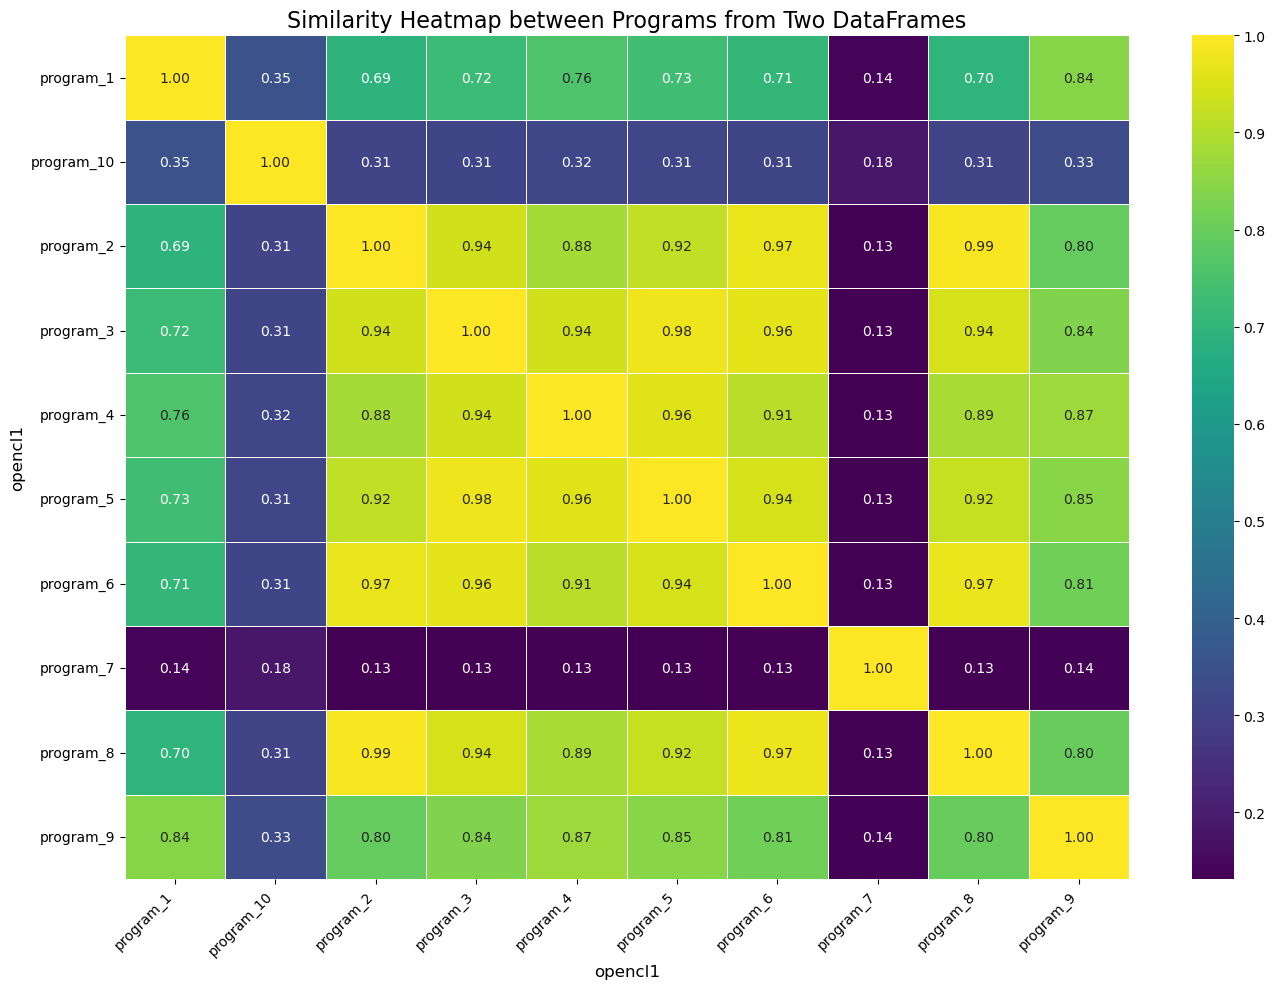

Heatmap saved to 'assets/robust_similarity_heatmap_opencl1.png'


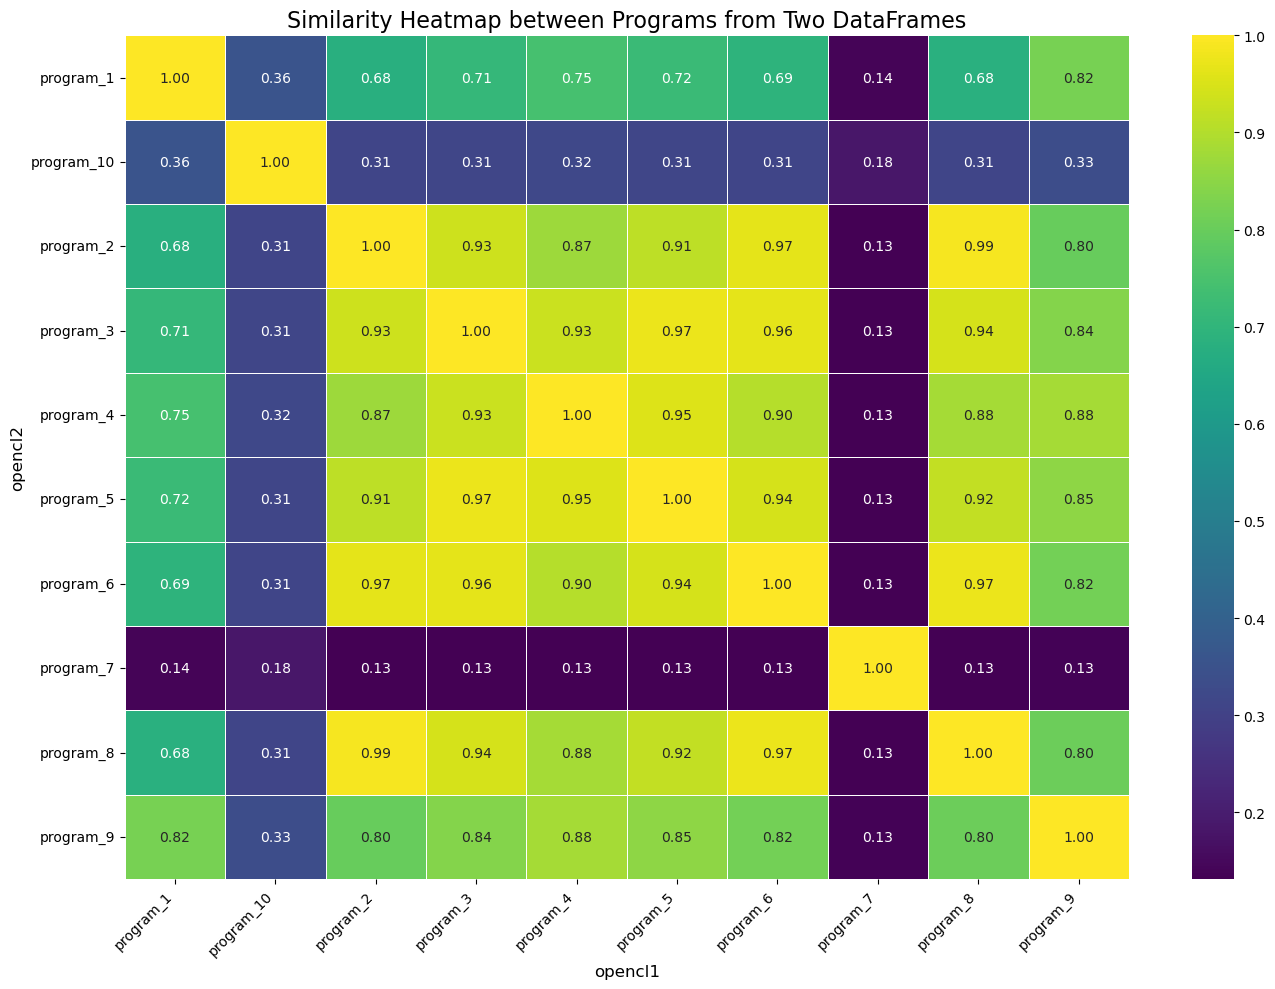

Heatmap saved to 'assets/robust_similarity_heatmap_opencl1_2.png'


In [18]:
create_comparison_heatmap(df_opencl_mean,df_opencl_mean,xlabel="opencl1",ylabel="opencl1",output_filename='assets/robust_similarity_heatmap_opencl1.png')
create_comparison_heatmap(df_opencl_mean,df_opencl_mean2,xlabel="opencl1",ylabel="opencl2",output_filename='assets/robust_similarity_heatmap_opencl1_2.png')

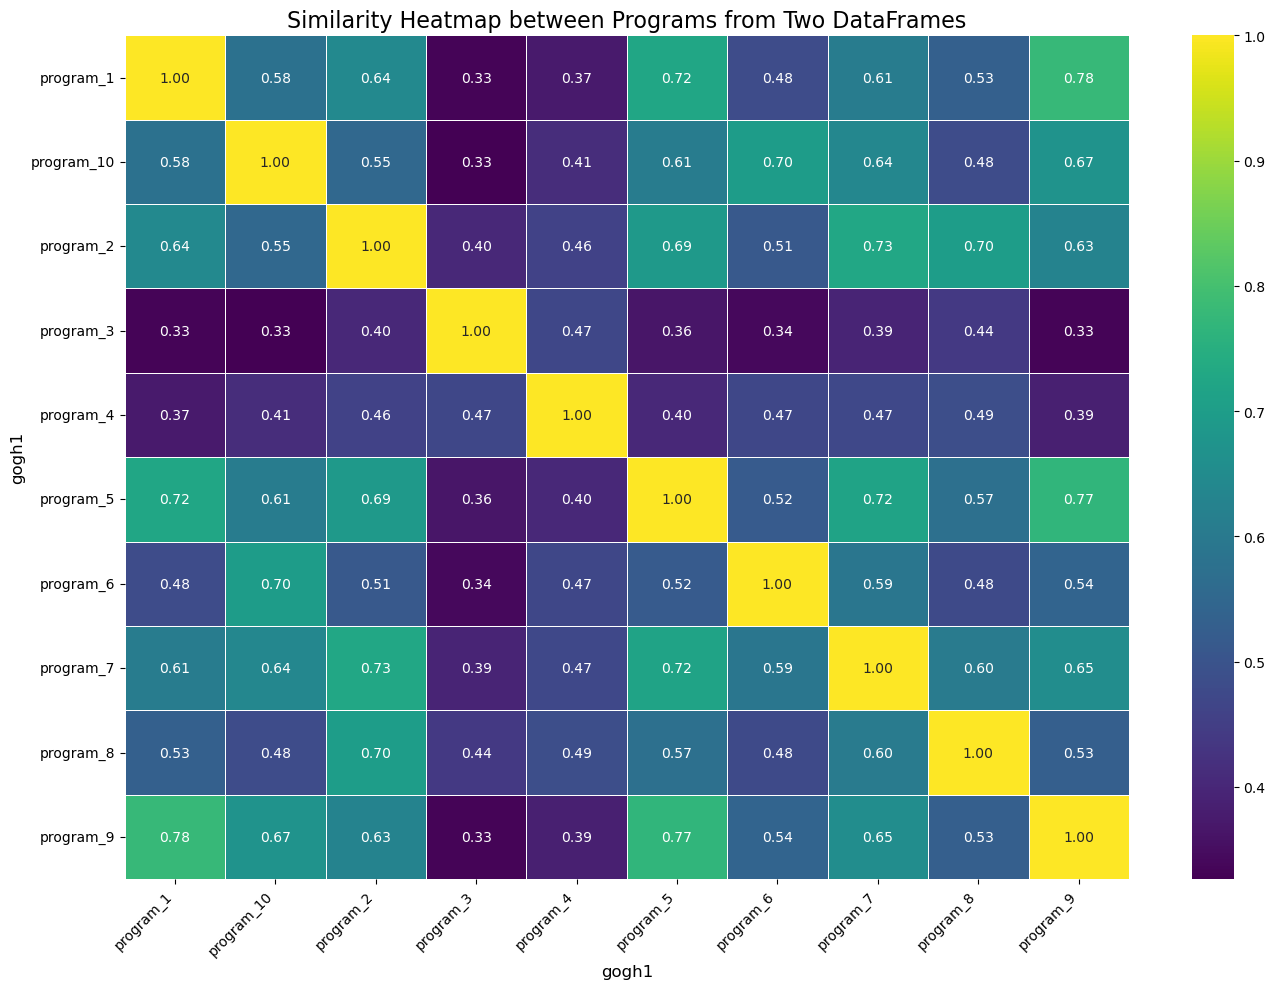

Heatmap saved to 'assets/robust_similarity_heatmap_gogh1.png'


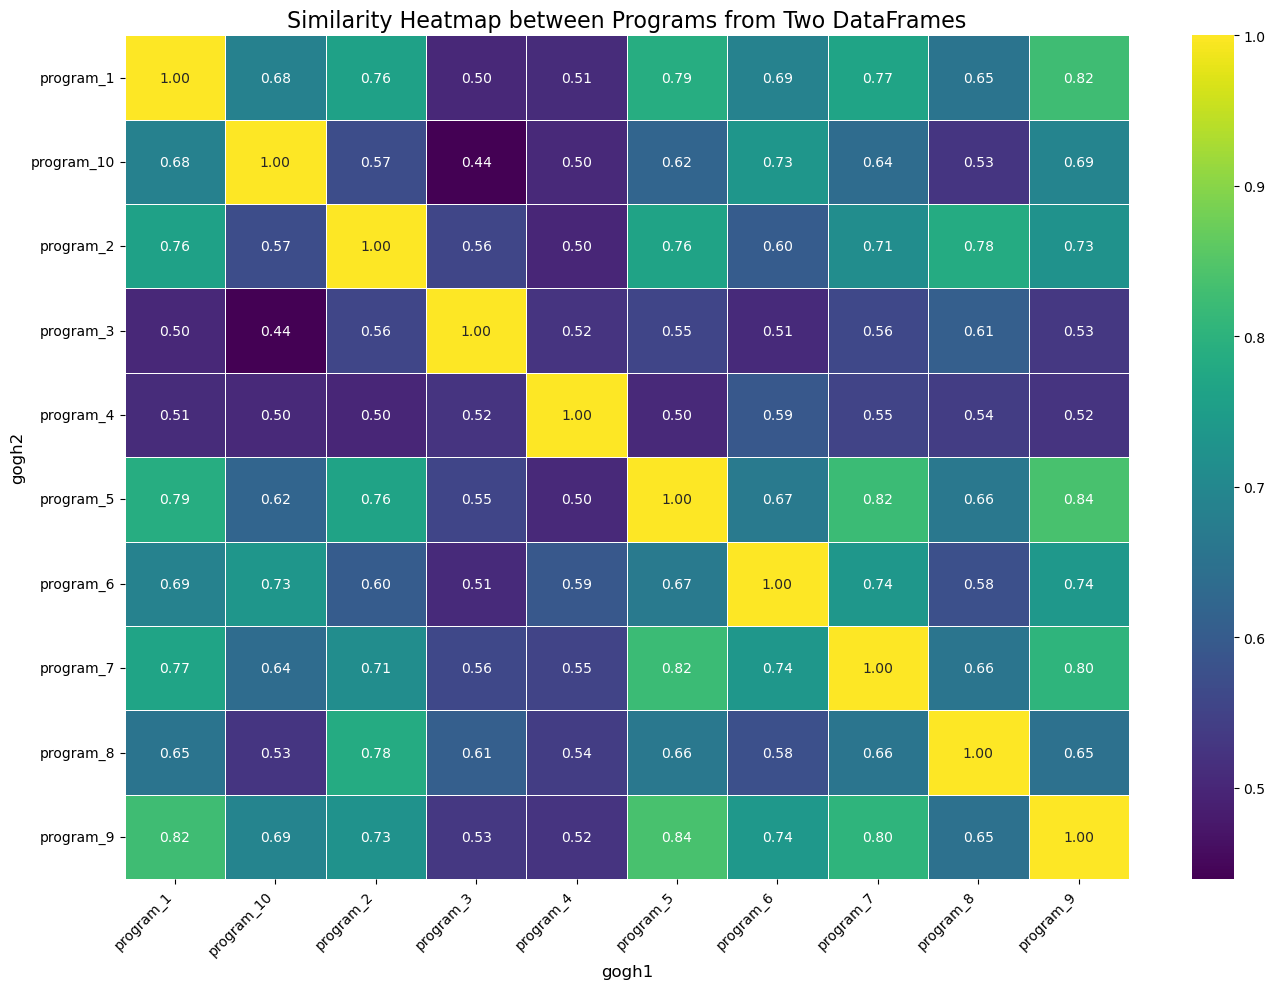

Heatmap saved to 'assets/robust_similarity_heatmap_gogh1_2.png'


In [19]:
create_comparison_heatmap(df_gogh_mean,df_gogh_mean,xlabel="gogh1",ylabel="gogh1",output_filename='assets/robust_similarity_heatmap_gogh1.png')
create_comparison_heatmap(df_gogh_mean,df_gogh_mean2,xlabel="gogh1",ylabel="gogh2",output_filename='assets/robust_similarity_heatmap_gogh1_2.png')

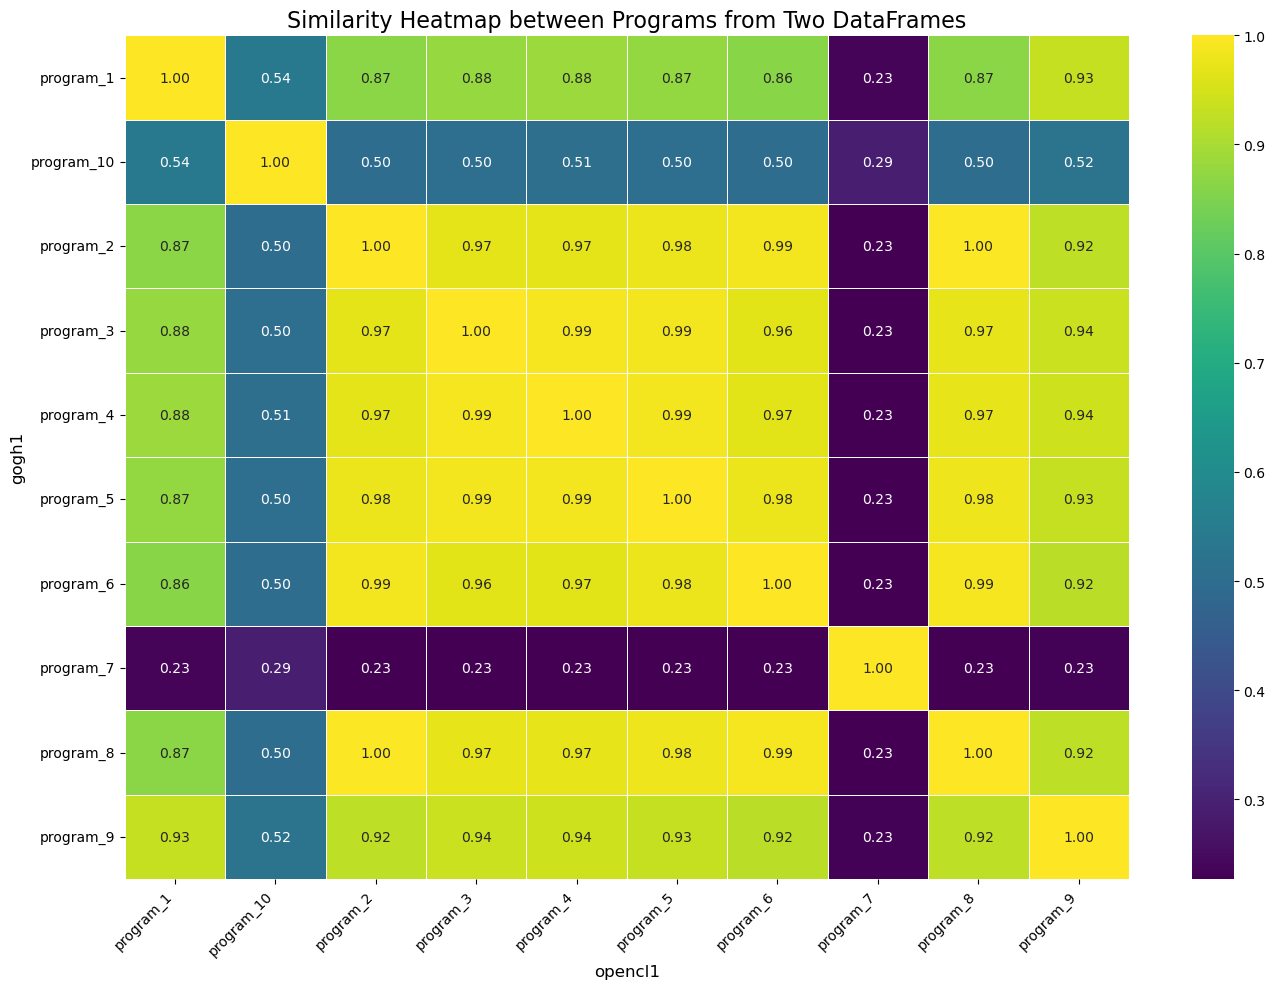

Heatmap saved to 'assets/robust_similarity_heatmap_vs1.png'


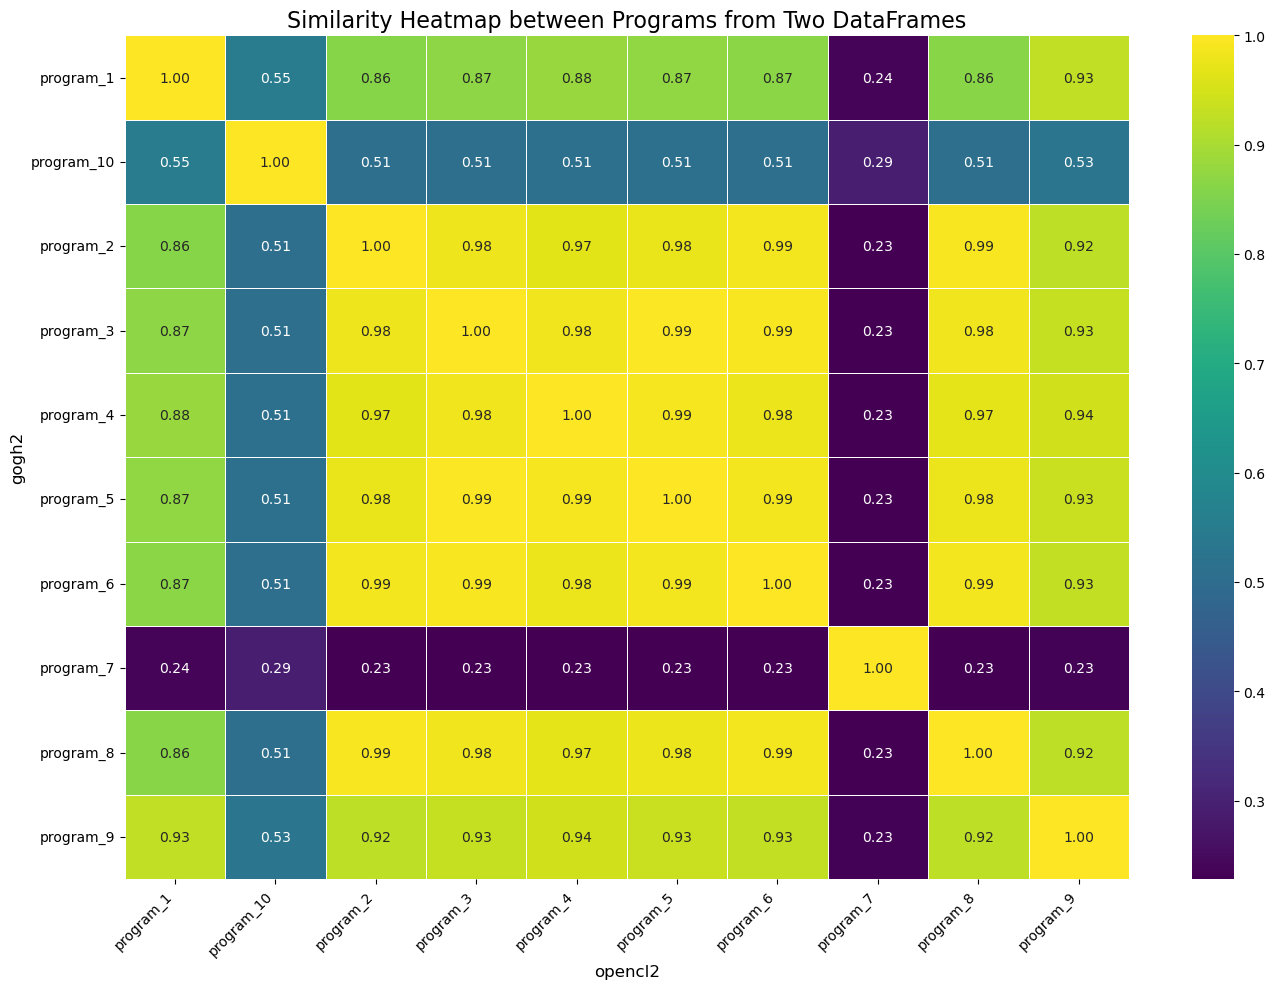

Heatmap saved to 'assets/robust_similarity_heatmap_vs2.png'


In [20]:
create_comparison_heatmap(df_opencl_mean,df_gogh_mean,xlabel="opencl1",ylabel="gogh1",output_filename='assets/robust_similarity_heatmap_vs1.png')
create_comparison_heatmap(df_opencl_mean2,df_gogh_mean2,xlabel="opencl2",ylabel="gogh2",output_filename='assets/robust_similarity_heatmap_vs2.png')

#### Plots

In [ ]:
counters_to_analyze = ["cpu-cycles", "instructions", "cache-misses", "cache-references"]

analysis_results = analyze_and_plot_distributions(
    dataframe=df_gogh,
    program_column='program',
    counters=counters_to_analyze,
    output_csv_filename='../data/prediction_test/shapiro_wilk_results_gogh.csv',
    plot=True
)

In [ ]:
analysis_results = analyze_and_plot_distributions(
    dataframe=df_opencl,
    program_column='program',
    counters=counters_to_analyze,
    output_csv_filename='../data/prediction_test/shapiro_wilk_results_opencl.csv',
    plot=True
)

In [ ]:
ks_results = compare_and_plot_distributions(
    df_gpt=df_gpt,
    df_gogh=df_gogh,
    df_opencl=df_opencl,
    counters=counters_to_analyze,
    output_csv_filename='../data/prediction_test/kstest_results_gpt.csv',
    plot = True
)

In [ ]:
comparions = compare_distributions(
    df1=df_gogh, name1='gogh',
    df2=df_opencl, name2='opencl',
    program_col='program',
    counters=counters_to_analyze,
    output_csv_filename='../data/prediction_test/gogh_vs_opencl_results.csv',
    plot=True
)

In [ ]:
df_shapiro_gogh = pd.read_csv('../data/prediction_test/shapiro_wilk_results_gogh.csv')
df_shapiro_opencl = pd.read_csv('../data/prediction_test/shapiro_wilk_results_opencl.csv')
df_ks = pd.read_csv('../data/prediction_test/kstest_results.csv')

shapiro_significant_gogh = df_shapiro_gogh[df_shapiro_gogh['p_value'] > 0.05]
shapiro_significant_opencl = df_shapiro_opencl[df_shapiro_opencl['p_value'] > 0.05]
ks_significant = df_ks[df_ks['p_value'] > 0.05]

if not shapiro_significant_gogh.empty:
    shapiro_counts = shapiro_significant_gogh['counter'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=shapiro_counts.index, y=shapiro_counts.values, palette='viridis')
    plt.title('Shapiro-Wilk GOGH: Count of Tests with P-Value > 0.05', fontsize=16)
    plt.ylabel('Number of Programs', fontsize=12)
    plt.xlabel('Performance Metric', fontsize=12)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('assets/shapiro_wilk_gogh.png')
    
if not shapiro_significant_opencl.empty:
    shapiro_counts = shapiro_significant_opencl['counter'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=shapiro_counts.index, y=shapiro_counts.values, palette='viridis')
    plt.title('Shapiro-Wilk OPENCL: Count of Tests with P-Value > 0.05', fontsize=16)
    plt.ylabel('Number of Programs', fontsize=12)
    plt.xlabel('Performance Metric', fontsize=12)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('assets/shapiro_wilk_p_opencl.png')

if not ks_significant.empty:
    ks_counts = ks_significant['counter'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=ks_counts.index, y=ks_counts.values, palette='plasma')
    plt.title('Kolmogorov-Smirnov: Count of Tests with P-Value > 0.05', fontsize=16)
    plt.ylabel('Number of Comparisons', fontsize=12)
    plt.xlabel('Performance Metric', fontsize=12)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('assets/ks_test_p_value_counts.png')

In [ ]:
create_similarity_heatmap

### Setup

In [ ]:
def extract_perf_vector(perf_string: str) -> list[float]:

    lines = perf_string.strip().split('\n')
    
    for line in lines:
        if ',' in line and any(char.isdigit() for char in line):
            value_strings = line.split(',')
            
            try:
                perf_vector = [float(val) for val in value_strings]
                return perf_vector
            except ValueError:
                continue
                
    raise Exception("No Vector predicted.")

In [ ]:
def in_confidence_interval(attr: str, value: float, series) -> bool:
    """
    Checks if a value falls within the confidence interval stored in a pandas Series/DataFrame row.
    """
    low_col = attr + "_ic_low"
    high_col = attr + "_ic_high"
    low_bound = float(series[low_col].iloc[0])
    high_bound = float(series[high_col].iloc[0])

    return low_bound <= value <= high_bound

In [ ]:
def prediction_gen_stats(data,models,df_guima,df_natan,api_asker):
    generate_data = DataLoader("../data/prediction_test/results.csv")
    for model in models:
        for dic in data:
            try:
                output = api_asker(prompt=dic["instruction"],model_name=model)
                perf_pred = extract_perf_vector(output)
                
                s_guima = df_guima[df_guima["Program"] == dic["program"]]
                s_natan = df_natan[df_natan["Program"] == dic["program"]]
            
                if s_natan.empty and dic["destination"] == "natan": 
                    continue
                elif not s_natan.empty and dic["destination"] == "natan":
                    result_cpu = in_confidence_interval(attr="cpu-cycles",value=perf_pred[0],series=s_natan)
                    result_instructions = in_confidence_interval(attr="instructions",value=perf_pred[1],series=s_natan)
                    result_cache_ref = in_confidence_interval(attr="cache-references",value=perf_pred[2],series=s_natan)
                    result_cache_misses = in_confidence_interval(attr="cache-misses",value=perf_pred[3],series=s_natan)
                    generate_data.new_row([dic["program"],model,perf_pred[0],perf_pred[1],perf_pred[2],perf_pred[3],"guima","natan",result_cpu,result_instructions,result_cache_ref,result_cache_misses])
            
                if s_guima.empty and dic["destination"] == "guima": 
                    continue
                elif not s_guima.empty and dic["destination"] == "guima":
                    result_cpu = in_confidence_interval(attr="cpu-cycles",value=perf_pred[0],series=s_guima)
                    result_instructions = in_confidence_interval(attr="instructions",value=perf_pred[1],series=s_guima)
                    result_cache_ref = in_confidence_interval(attr="cache-references",value=perf_pred[2],series=s_guima)
                    result_cache_misses = in_confidence_interval(attr="cache-misses",value=perf_pred[3],series=s_guima)
                    generate_data.new_row([dic["program"],model,perf_pred[0],perf_pred[1],perf_pred[2],perf_pred[3],"natan","guima",result_cpu,result_instructions,result_cache_ref,result_cache_misses])
                
                generate_data.save()
            
            except Exception as e:
                print(f"Error:{e}")    
    
    

In [ ]:
def prediction_gen_qualitative(data,models,df_guima,df_natan,api_asker):
    generated_data = []
    for model in models:
        for dic in data:
            try:
                output = api_asker(prompt=dic["instruction"],model_name=model)
                generated_data.append({"output":output, "program" : dic["program"], "origin":dic["origin"], "destination": dic["destination"]})
            except Exception as e:
                print(f"Error:{e}")
    
    with open("../data/prediction_test/output_qualitative.jsonl", "w", encoding="utf-8") as jsonl_file:
        for entry in generated_data:
            jsonl_file.write(json.dumps(entry) + "\n")    

In [ ]:
def plot_histogram(df, attr,figname,operation):
    plt.figure(figsize=(10, 6))
    plt.hist(df[attr], bins=30, edgecolor='black', alpha=0.7)
    plt.title(operation)
    plt.xlabel(f'Diferença em {attr} - {operation}')
    plt.ylabel('Frequência')
    plt.grid(True)
    output_plot_path = f"assets/{attr}_{figname}_{operation}_distribution.png"
    plt.savefig(output_plot_path)
    plt.show()
    plt.close()

In [ ]:
def mean_distribution(df_a, df_b, counter,operation,norm):
    counter_mean = counter + "_mean"

    if counter_mean not in df_a.columns or counter_mean not in df_b.columns:
        print(f"Erro: '{counter_mean}' was not found.")
        return

    df_a_means = df_a[counter_mean]
    df_b_means = df_b[counter_mean]
    

    print(counter)
    means = []
    for _ in range(100000):
        temp_a = df_a_means.sample(n=4, replace=True)
        temp_b = df_b_means.sample(n=4, replace=True)
        means.append(np.mean(temp_a) - np.mean(temp_b))

    normalized_mean = np.array(means)
    norm = np.linalg.norm(normalized_mean)
    normalized_mean = normalized_mean / norm

    df_means = pd.DataFrame({counter_mean: means})
    df_means_norm = pd.DataFrame({counter_mean: normalized_mean})

    output_csv_path = f"../data/prediction_test/distributions/{counter_mean}{operation}_distribution.csv"
    output_norm_csv_path = f"../data/prediction_test/distributions/{counter_mean}_norm_{operation}_distribution.csv"
    
    df_means.to_csv(output_csv_path, index=False)
    df_means_norm.to_csv(output_norm_csv_path, index=False)

    if norm is True:
        plot_histogram(df_means_norm,counter_mean,counter,operation)
    else:
        plot_histogram(df_means,counter_mean,counter,operation)

In [ ]:
def question_dist(list,operation):
    series = pd.Series(list)

    series = series.value_counts()

    plt.figure(figsize=(10, 7))
    series.plot(kind='bar', color='lightcoral')

    plt.title(f"Frequência das Respostas de {operation}", fontsize=16)
    plt.ylabel("Quantidade de Ocorrências", fontsize=12)
    plt.xlabel("Respostas", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.savefig(f'assets/grafico_respostas_{operation}.png')

### Prediction

In [ ]:
input_data = []

with open('../data/prediction_test/test.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        line_dict = ast.literal_eval(line)
        input_data.append(line_dict)


### Graphs

In [ ]:
results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

with open('../data/prediction_test/test.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        question = json.loads(line)
        counter = question.get("counter")
        origin = question.get("origin")
        q_type = question.get("type")
        answer = question.get("answer")

        if counter and origin and q_type and answer:
            results[counter][origin][q_type].append(answer)


for counter, origins in results.items():
    for origin, types in origins.items():
        for q_type, answers in types.items():
            if q_type == "random_qualitative":
                operation_name = f"{counter}_{origin}_{q_type}"
                question_dist(answers, operation_name)

In [ ]:
df = pd.read_csv("../data/prediction_test/models_question.csv")

accuracy = df.groupby('model')['is_correct'].value_counts(normalize=True).unstack()
accuracy_percent = (accuracy[True] * 100).sort_values(ascending=False)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(accuracy_percent.index, accuracy_percent.values, color=['#4C72B0', '#55A868', '#C44E52', '#8172B2'])

ax.set_title('Model Accuracy on Qualitative Questions', fontsize=16, fontweight='bold')
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=0, ha='center')
plt.tight_layout()

plt.savefig('assets/model_accuracy_comparison.png')
